In [23]:
import pandas as pd
import numpy as np
#loading NASA turbine engine sensor data
dataset1= pd.read_csv("/kaggle/input/nasa-turbine-jet-engine-failure-dataset/train_FD001.csv",sep='\s+', header=None)
dataset2= pd.read_csv("/kaggle/input/nasa-turbine-jet-engine-failure-dataset/train_FD002.csv",sep='\s+', header=None)
dataset3= pd.read_csv("/kaggle/input/nasa-turbine-jet-engine-failure-dataset/train_FD003.csv",sep='\s+', header=None)
dataset4= pd.read_csv("/kaggle/input/nasa-turbine-jet-engine-failure-dataset/train_FD004.csv",sep='\s+', header=None)


In [25]:
columns = ['engine_id', 'cycle', 
           'altitude', 'mach_number', 'sea_level_temp', 
           'T2', 'T24', 'T30', 'T50', 'P2', 'P15', 'P30', 
           'Nf', 'Nc', 'epr', 'Ps30', 'phi', 'NRf', 'NRe', 
           'BPR', 'farB', 'htBleed', 'Nf_dmd', 'PCNfR_dmd', 'W31', 'W32'] 
dataset1.columns = columns 
dataset2.columns = columns 
dataset3.columns = columns 
dataset4.columns = columns 

In [18]:
print(dataset4.describe().tail(4).T)

                      25%        50%        75%        max
engine_id         60.0000   126.0000   185.0000   249.0000
cycle             62.0000   123.0000   191.0000   543.0000
altitude          10.0046    25.0014    41.9981    42.0080
mach_number        0.2507     0.7000     0.8400     0.8420
sea_level_temp   100.0000   100.0000   100.0000   100.0000
T2               445.0000   462.5400   491.1900   518.6700
T24              549.3300   555.7400   607.0700   644.4200
T30             1350.5500  1367.6800  1497.4200  1613.0000
T50             1119.4900  1136.9200  1302.6200  1440.7700
P2                 3.9100     7.0500    10.5200    14.6200
P15                5.7200     9.0300    15.4800    21.6100
P30              142.9200   194.9600   394.2800   570.8100
Nf              2211.9500  2223.0700  2323.9300  2388.6400
Nc              8320.5900  8362.7600  8777.2500  9196.8100
epr                1.0200     1.0300     1.2600     1.3200
Ps30              41.7600    42.3300    45.2200    48.36

In [26]:
# drop constant and uncecessary columns:
drop_cols = ['sea_level_temp', 'PCNfR_dmd']
dataset4 = dataset4.drop(columns=drop_cols)

In [ ]:
dataset4['RUL'] = dataset4.groupby('engine_id')['cycle'].transform(lambda x: x.max() - x)

In [ ]:
# Piecewise linear degradation 
#Cap RUL at 125 cycles
dataset4['RUL'] = dataset4['RUL'].clip(upper=125)
dataset4

In [33]:
#checking RUL statistics
print(dataset4["RUL"].describe().tail(4))

25%     61.0
50%    122.0
75%    125.0
max    125.0
Name: RUL, dtype: float64


# GMM Gaussian Mixture Modelling

In [35]:
GMMdata4 = dataset4.copy()
useful_features = [
    'altitude', 'mach_number',
    'T2', 'T24', 'T30', 'T50',
    'P2', 'P15', 'P30',
    'Nf', 'Nc', 'NRe', 'NRf',
    'BPR', 'farB', 'phi', 'htBleed',
    'W31', 'W32'
]
# Keep only useful features
GMMdata4 = GMMdata4[useful_features]
GMMdata4.head(3)

altitude  mach_number      T2     T24      T30      T50    P2    P15  \
0   42.0049       0.8400  445.00  549.68  1343.43  1112.93  3.91   5.70   
1   20.0020       0.7002  491.19  606.07  1477.61  1237.50  9.35  13.61   
2   42.0038       0.8409  445.00  548.95  1343.12  1117.05  3.91   5.69   

      P30       Nf       Nc      NRe      NRf     BPR  farB     phi  htBleed  \
0  137.36  2211.86  8311.32  8074.83  2387.99  9.3335  0.02  129.78      330   
1  332.10  2323.66  8713.60  8046.13  2387.73  9.1913  0.02  312.59      361   
2  138.18  2211.92  8306.69  8066.62  2387.97  9.4007  0.02  129.62      329   

     W31      W32  
0  10.62   6.3670  
1  24.37  14.6552  
2  10.48   6.4213

In [36]:
from sklearn.preprocessing import StandardScaler
# Scaling the features using StandardScaler 
scaler = StandardScaler()
GMMdata_scaled = scaler.fit_transform(GMMdata4)

In [37]:
from sklearn.mixture import GaussianMixture

# -------------------------------------------
# Multi-Class Engine Health State Derivation using GMM
# -------------------------------------------
# Clustering engine cycles into 3 meaningful states:
#   0 = Healthy (far from failure)
#   1 = Degrading (approaching failure)
#   2 = Critical (very close to failure)
# We rely on full covariance to capture correlations across sensor features.
# Reordering clusters based on mean RUL ensures semantic consistency.
# -------------------------------------------

n_clusters = 3  # Multi-class health states

# Initialize the GMM model with careful hyperparameters for complex sensor patterns
gmm_model = GaussianMixture(
    n_components=n_clusters,
    covariance_type='full',
    random_state=42,
    tol=1e-4,
    max_iter=500,
    n_init=5
)

# Fit GMM on the scaled sensor matrix
gmm_model.fit(GMMdata_scaled)

# Initial cluster assignments (labels arbitrary)
raw_labels = gmm_model.predict(GMMdata_scaled)

# Map cluster labels to meaningful health states using average RUL
cluster_means = {}
for cluster in range(n_clusters):
    cluster_means[cluster] = dataset4['RUL'][raw_labels == cluster].mean()

# Sort clusters by increasing severity (higher RUL = healthier)
sorted_clusters = sorted(cluster_means, key=lambda k: cluster_means[k], reverse=True)
label_mapping = {old: new for new, old in enumerate(sorted_clusters)}

# Apply mapping to get semantically ordered labels
health_labels = np.array([label_mapping[label] for label in raw_labels])
dataset4['health_state'] = health_labels

# Optional sanity check
health_counts = pd.Series(health_labels).value_counts().sort_index()
print("Multi-class cluster distribution:\n", health_counts)


Multi-class cluster distribution:
 0    18315
1    33696
2     9238
Name: count, dtype: int64


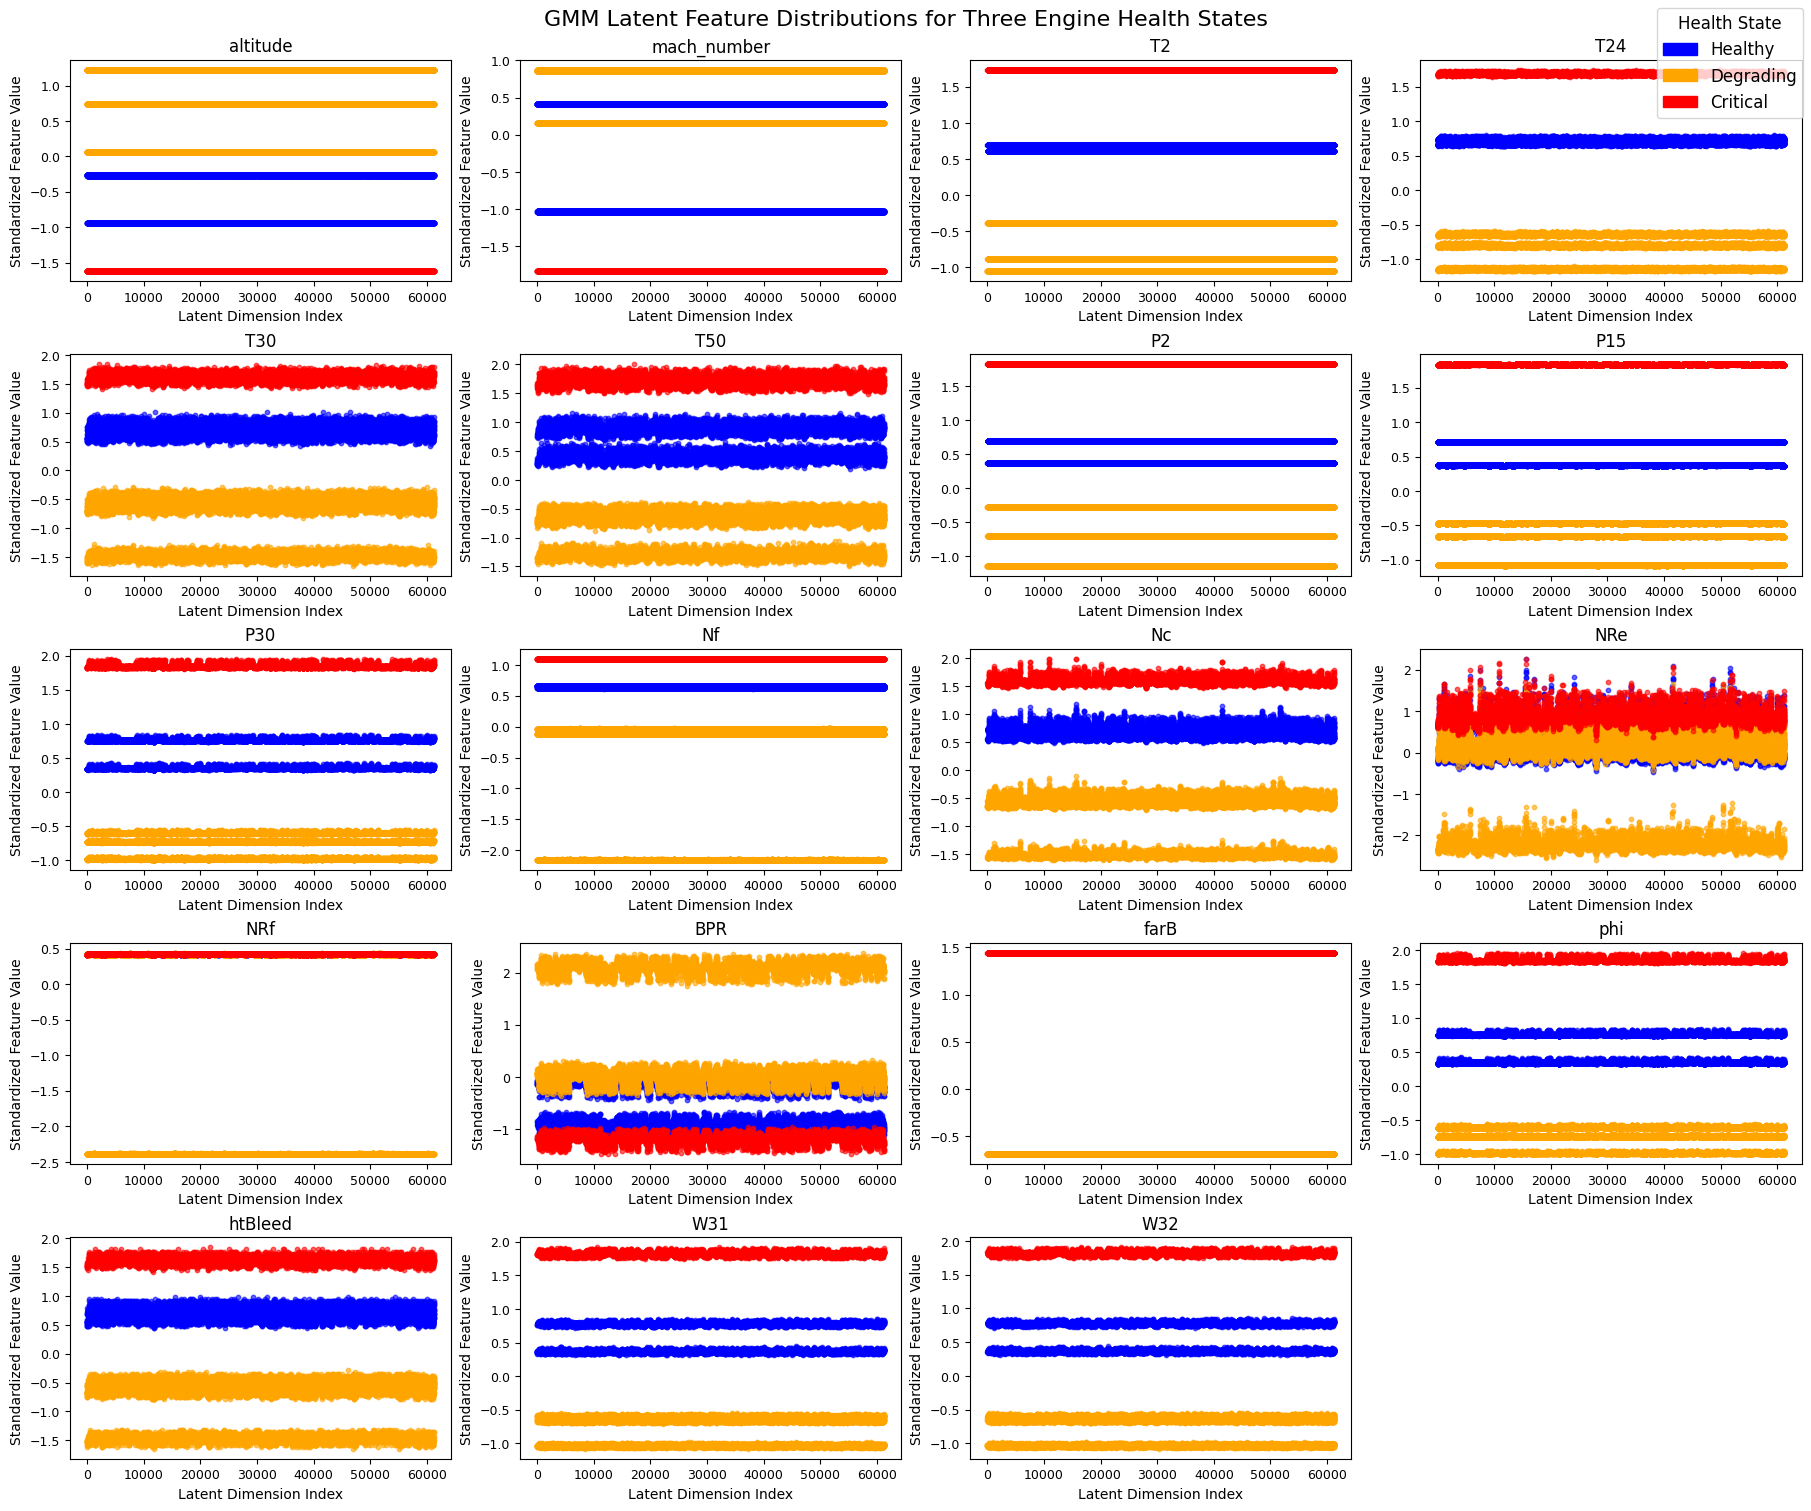

In [45]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

plot_data = pd.DataFrame(GMMdata_scaled, columns=GMMdata4.columns)
plot_data['health_state'] = dataset4['health_state'].values
plot_data['cycle_index'] = dataset4.index

features_to_plot = GMMdata4.columns.tolist()
n_features = len(features_to_plot)
n_cols = 4
n_rows = (n_features + n_cols - 1) // n_cols

colors = {0: 'blue', 1: 'orange', 2: 'red'}
labels = {0: 'Healthy', 1: 'Degrading', 2: 'Critical'}

fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 3*n_rows), constrained_layout=True)

for i, feature in enumerate(features_to_plot):
    row = i // n_cols
    col = i % n_cols
    ax = axes[row, col] if n_rows > 1 else axes[col]
    for state in [0,1,2]:
        subset = plot_data[plot_data['health_state'] == state]
        ax.scatter(subset['cycle_index'], subset[feature], s=10, alpha=0.6, color=colors[state])
    ax.set_title(feature, fontsize=12)
    ax.set_xlabel('Latent Dimension Index', fontsize=10)
    ax.set_ylabel('Standardized Feature Value', fontsize=10)
    ax.tick_params(axis='both', labelsize=9)

for j in range(i+1, n_rows*n_cols):
    row = j // n_cols
    col = j % n_cols
    ax = axes[row, col] if n_rows > 1 else axes[col]
    ax.axis('off')

legend_handles = [mpatches.Patch(color=colors[i], label=labels[i]) for i in [0,1,2]]
fig.legend(handles=legend_handles, loc='upper right', fontsize=12, title='Health State', title_fontsize=12)
fig.suptitle('GMM Latent Feature Distributions for Three Engine Health States', fontsize=16)
plt.show()


Silhouette Score: 0.6577328179097047
Cluster 0 RUL stats:
 count    18315.000000
mean        93.098771
std         40.661238
min          0.000000
25%         61.000000
50%        123.000000
75%        125.000000
max        125.000000
Name: RUL, dtype: float64 

Cluster 1 RUL stats:
 count    33696.000000
mean        92.989702
std         40.694522
min          0.000000
25%         61.000000
50%        122.000000
75%        125.000000
max        125.000000
Name: RUL, dtype: float64 

Cluster 2 RUL stats:
 count    9238.000000
mean       92.743559
std        40.568726
min         0.000000
25%        61.000000
50%       121.000000
75%       125.000000
max       125.000000
Name: RUL, dtype: float64 



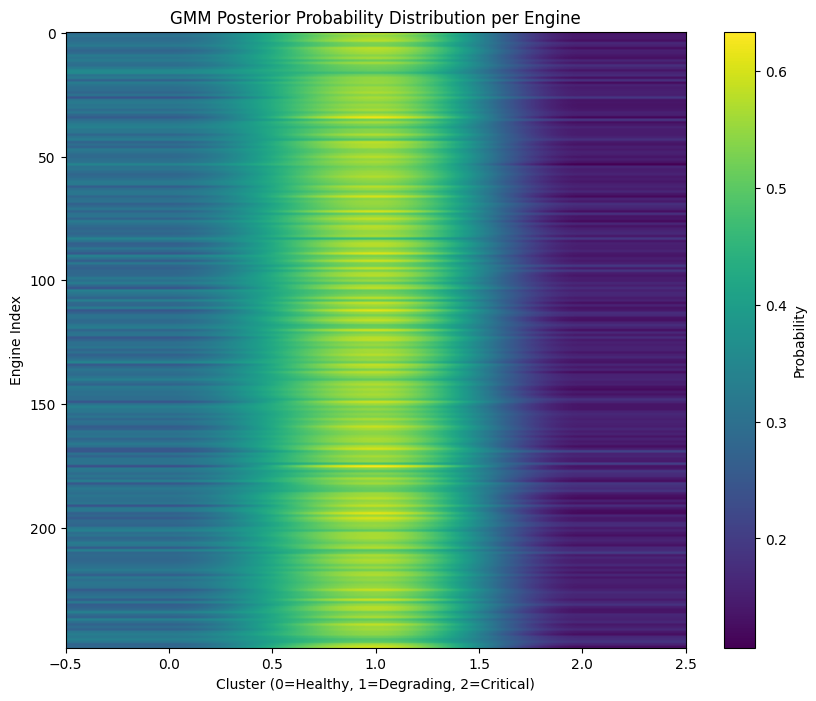

Average clustering confidence: 0.5506117007780439


In [48]:
# Evaluating our GMM clustering 
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score

# --- Fit GMM ---
n_clusters = 3
gmm_model = GaussianMixture(
    n_components=n_clusters,
    covariance_type='full',
    random_state=42,
    tol=1e-4,
    max_iter=500,
    n_init=5
)
gmm_model.fit(GMMdata_scaled)

# Cluster labels
health_labels = gmm_model.predict(GMMdata_scaled)
dataset4['health_state'] = health_labels
GMMdata4['health_state'] = health_labels

# --- Silhouette Score ---
sil_score = silhouette_score(GMMdata_scaled, health_labels)
print("Silhouette Score:", sil_score)

# --- RUL stats per cluster ---
for state in range(n_clusters):
    subset = dataset4[dataset4['health_state'] == state]
    print(f"Cluster {state} RUL stats:\n", subset['RUL'].describe(), "\n")

# --- Posterior probabilities ---
posterior_probs = gmm_model.predict_proba(GMMdata_scaled)

# Aggregate per engine
engine_ids = dataset4['engine_id'].unique()
engine_posteriors = []
for eng in engine_ids:
    eng_rows = dataset4['engine_id'] == eng
    avg_probs = posterior_probs[eng_rows].mean(axis=0)
    engine_posteriors.append(avg_probs)
engine_posteriors = np.array(engine_posteriors)  # shape: (n_engines, n_clusters)

# --- Visualize posterior probabilities ---
plt.figure(figsize=(10,8))
plt.imshow(engine_posteriors, aspect='auto', cmap='viridis')
plt.colorbar(label='Probability')
plt.xlabel('Cluster (0=Healthy, 1=Degrading, 2=Critical)')
plt.ylabel('Engine Index')
plt.title('GMM Posterior Probability Distribution per Engine')
plt.show()

# --- Average clustering probability ---
avg_confidence = engine_posteriors.max(axis=1).mean()
print("Average clustering confidence:", avg_confidence)

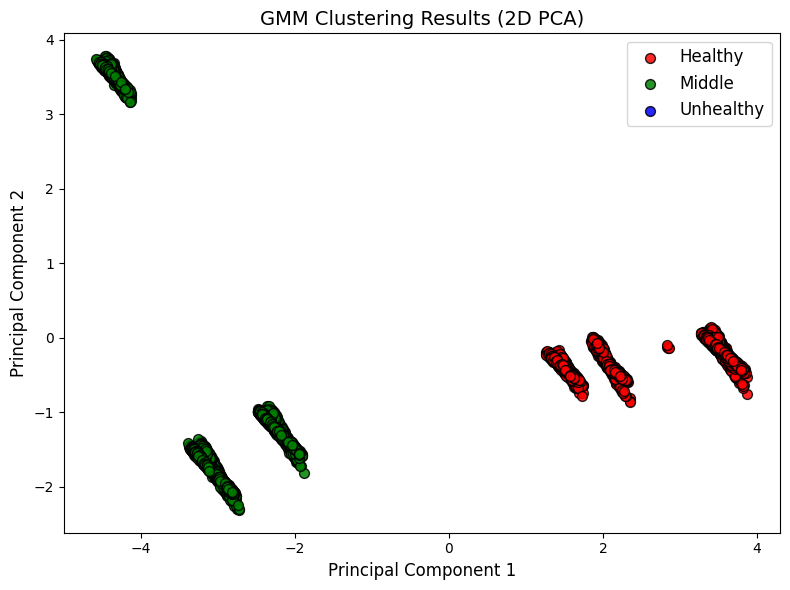

In [54]:
import matplotlib.pyplot as plt

# Map numeric cluster labels to colors and text
color_map = {0: 'red', 1: 'green', 2: 'blue'}
label_map = {0: 'Healthy', 1: 'Middle', 2: 'Unhealthy'}

plt.figure(figsize=(8,6))
for cluster in sorted(dataset4['health_state'].unique()):
    subset = pca_df[pca_df['health_state'] == label_map[cluster]]
    plt.scatter(subset['PC1'], subset['PC2'],
                c=color_map[cluster], label=label_map[cluster],
                s=50, edgecolor='k', alpha=0.85)

plt.xlabel('Principal Component 1', fontsize=12)
plt.ylabel('Principal Component 2', fontsize=12)
plt.title('GMM Clustering Results (2D PCA)', fontsize=14)
plt.legend(fontsize=12)
plt.grid(False)
plt.tight_layout()
plt.show()


In [53]:
import plotly.express as px
from sklearn.decomposition import PCA

# -------------------------------------------
# 3D PCA Projection of GMM Clusters (3 states)
# -------------------------------------------

# Reduce to 3D for visualization
pca = PCA(n_components=3, random_state=42)
pca_proj = pca.fit_transform(GMMdata_scaled)

# Create DataFrame for plotting
pca_df = pd.DataFrame({
    'PC1': pca_proj[:, 0],
    'PC2': pca_proj[:, 1],
    'PC3': pca_proj[:, 2],
    'health_state': dataset4['health_state']
})

# Fluorescent color mapping
color_map = {
    0: "#39FF14",   # neon green → Healthy
    1: "#1F51FF",   # neon navy blue → Middle
    2: "#FF073A"    # neon red → Critical
}
legend_map = {
    0: "Healthy",
    1: "Middle",
    2: "Critical"
}

# Map numeric labels to descriptive
pca_df['health_state'] = pca_df['health_state'].map(legend_map)

# Interactive 3D scatter plot
fig = px.scatter_3d(
    pca_df,
    x='PC1', y='PC2', z='PC3',
    color='health_state',
    color_discrete_map=color_map,
    opacity=0.8,
    title="3D PCA Projection of GMM Clusters for Engine Data",
    labels={'PC1': f"PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)",
            'PC2': f"PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)",
            'PC3': f"PC3 ({pca.explained_variance_ratio_[2]*100:.1f}%)"}
)

# Layout enhancements
fig.update_layout(
    width=900, height=700,
    title_font=dict(size=20),
    legend_title=dict(text="Health State", font=dict(size=14)),
    legend=dict(font=dict(size=13), y=0.99, x=0.99, bgcolor="rgba(255,255,255,0.7)"),
    scene=dict(
        xaxis=dict(showgrid=True, gridcolor='lightgrey'),
        yaxis=dict(showgrid=True, gridcolor='lightgrey'),
        zaxis=dict(showgrid=True, gridcolor='lightgrey')
    )
)

fig.show()


In [58]:
# HYBRID APPROACH:
# -----------------------------
# Step 1: Preprocess dataset4 for DTW clustering
# -----------------------------

# 1. Select relevant features (exclude IDs, cycle, target/health_state)
sensor_features = [
    'altitude', 'mach_number', 'T2', 'T24', 'T30', 'T50',
    'P2', 'P15', 'P30', 'Nf', 'Nc', 'epr', 'Ps30', 'phi',
    'NRf', 'NRe', 'BPR', 'farB', 'htBleed', 'Nf_dmd', 'W31', 'W32'
]

# Keep only engine_id + cycle + selected sensors
engine_sensor_data = dataset4[['engine_id', 'cycle'] + sensor_features].copy()

# 2. Normalize sensor readings per engine
def normalize_engine_trajectory(engine_df):
    """
    Standardizes sensor readings per engine to mean=0, std=1
    """
    scaler = StandardScaler()
    engine_df[sensor_features] = scaler.fit_transform(engine_df[sensor_features])
    return engine_df

# Apply normalization engine-wise
normalized_engine_data = engine_sensor_data.groupby('engine_id').apply(
    normalize_engine_trajectory
).reset_index(drop=True)

# 3. Prepare dictionary of time-series per engine for DTW
# Structure: {engine_id: engine_df[sensor_features].values (numpy array)}
engine_trajectories = {
    engine_id: group[sensor_features].values
    for engine_id, group in normalized_engine_data.groupby('engine_id')
}


/tmp/ipykernel_36/2791453599.py:26: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



In [62]:
# PERFORMING CLUSTERING  (DTW + Hierarchical Clustering)
import numpy as np
from fastdtw import fastdtw
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from scipy.spatial.distance import squareform

# -----------------------------
# Step 2: DTW + Hierarchical Clustering
# -----------------------------

engine_ids = list(engine_trajectories.keys())
num_engines = len(engine_ids)

# 1. Initialize distance matrix
dtw_distance_matrix = np.zeros((num_engines, num_engines))

# 2. Compute pairwise DTW distances
# fastdtw is efficient approximation for long time-series
for i in range(num_engines):
    for j in range(i + 1, num_engines):
        trajectory_i = engine_trajectories[engine_ids[i]]
        trajectory_j = engine_trajectories[engine_ids[j]]
        distance, _ = fastdtw(trajectory_i, trajectory_j)
        dtw_distance_matrix[i, j] = distance
        dtw_distance_matrix[j, i] = distance  # symmetric matrix

# 3. Convert to condensed form for hierarchical clustering
condensed_dtw = squareform(dtw_distance_matrix)

# 4. Perform hierarchical clustering (Ward linkage recommended)
hierarchical_linkage = linkage(condensed_dtw, method='ward')


# 5. Assign cluster labels
# choose 3 clusters for health states
num_health_states = 3
cluster_labels = fcluster(hierarchical_linkage, num_health_states, criterion='maxclust')

# 7. Store cluster labels in a dictionary
engine_clusters = {engine_ids[i]: cluster_labels[i] for i in range(num_engines)}


In [64]:
# Add cluster labels to dataset4
dataset4['cluster_label'] = dataset4['engine_id'].map(engine_clusters)

# Group by cluster and calculate RUL statistics
cluster_rul_stats = dataset4.groupby('cluster_label')['RUL'].describe()
print(cluster_rul_stats)

                 count        mean        std  min    25%    50%    75%    max
cluster_label                                                                 
1              36304.0   87.690062  41.588632  0.0   52.0  105.0  125.0  125.0
2               2228.0  107.327199  34.158749  0.0  111.0  125.0  125.0  125.0
3              22717.0  100.040718  38.280003  0.0   78.0  125.0  125.0  125.0


In [67]:
# -----------------------------
# Step 3: Apply GMM for soft cluster assignment
# -----------------------------

from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA

# 1. Reduce DTW distance matrix to 2D using PCA (for GMM input)
pca = PCA(n_components=2, random_state=42)
dtw_pca = pca.fit_transform(dtw_distance_matrix)

# 2. Fit GMM with 3 components (for 3 health states)
gmm = GaussianMixture(n_components=3, covariance_type='full', random_state=42)
gmm.fit(dtw_pca)

# 3. Get soft probabilities for each engine
soft_probs = gmm.predict_proba(dtw_pca)  # shape: (num_engines, 3)

# 4. Map engine_id to soft probabilities
engine_ids = list(engine_trajectories.keys())
engine_soft_probs = {engine_ids[i]: soft_probs[i] for i in range(len(engine_ids))}

# 5.  get refined hard labels based on max probability
refined_labels = np.argmax(soft_probs, axis=1) + 1  # +1 to match cluster numbering
engine_refined_clusters = {engine_ids[i]: refined_labels[i] for i in range(len(engine_ids))}

# 6. Add refined clusters to dataset4
dataset4['cluster_label_refined'] = dataset4['engine_id'].map(engine_refined_clusters)


In [71]:
dataset4.groupby('cluster_label_refined')['RUL'].describe()


count        mean        std  min   25%    50%  \
cluster_label_refined                                                     
1                      19263.0   81.665628  41.807480  0.0  45.0   90.0   
2                      14229.0  103.969007  36.295771  0.0  93.0  125.0   
3                      27757.0   95.210217  40.062932  0.0  66.0  125.0   

                         75%    max  
cluster_label_refined                
1                      125.0  125.0  
2                      125.0  125.0  
3                      125.0  125.0

In [73]:
# evaluting Hybrid method
from sklearn.metrics import silhouette_score

# For refined clusters
silhouette_avg = silhouette_score(dtw_pca, dataset4.groupby('engine_id')['cluster_label_refined'].first().values)
print("Silhouette Score:", silhouette_avg)


Silhouette Score: 0.5230975279274608


   engine_id  refined_cluster  confidence  health_state
0          1                3    0.616988     Degrading
1          2                3    0.850552     Degrading
2          3                3    0.862486     Degrading
3          4                3    0.994742     Degrading
4          5                1    0.928844  Near-Failure


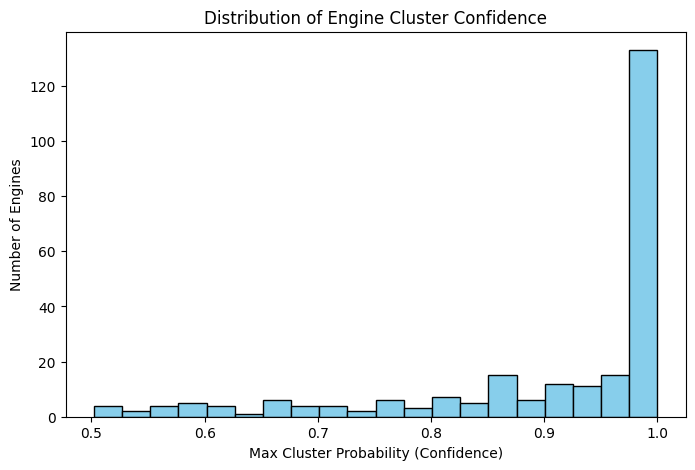

In [74]:
# 1. Compute max probability per engine as confidence
max_confidence = soft_probs.max(axis=1)

# 2. Map engine_id to confidence
engine_confidence = {engine_ids[i]: max_confidence[i] for i in range(len(engine_ids))}

# 3. Create a DataFrame for monitoring
engine_health_df = pd.DataFrame({
    'engine_id': engine_ids,
    'refined_cluster': refined_labels,       # GMM cluster assignment
    'confidence': max_confidence
})

#  map to interpretable health states
health_state_map = {1: 'Near-Failure', 3: 'Degrading', 2: 'Healthy'}
engine_health_df['health_state'] = engine_health_df['refined_cluster'].map(health_state_map)

# 4. Display first few rows
print(engine_health_df.head())

# 5. Visualize confidence distribution
plt.figure(figsize=(8,5))
plt.hist(max_confidence, bins=20, color='skyblue', edgecolor='black')
plt.xlabel("Max Cluster Probability (Confidence)")
plt.ylabel("Number of Engines")
plt.title("Distribution of Engine Cluster Confidence")
plt.show()

In [ ]:
# MAPPING TARGET 
# Map numeric refined clusters to interpretable health states
health_state_map = {
    1: 'Near-Failure',
    3: 'Degrading',
    2: 'Healthy'
}

# Create final target column in dataset4
dataset4['health_state_final'] = dataset4['cluster_label_refined'].map(health_state_map)

# Verify
dataset4[['engine_id','cluster_label_refined','health_state_final']].head()


In [ ]:
# Filter for Healthy engines
healthy_df = dataset4[dataset4['health_state_final'] == 'Healthy']

# Display first few rows
healthy_df[['engine_id', 'cluster_label_refined', 'health_state_final', 'RUL']].head(10)


In [97]:
dataset4.columns

Index(['engine_id', 'cycle', 'altitude', 'mach_number', 'T2', 'T24', 'T30',
       'T50', 'P2', 'P15', 'P30', 'Nf', 'Nc', 'epr', 'Ps30', 'phi', 'NRf',
       'NRe', 'BPR', 'farB', 'htBleed', 'Nf_dmd', 'W31', 'W32', 'RUL',
       'health_state', 'cluster_label', 'cluster_label_refined',
       'health_state_final'],
      dtype='object')

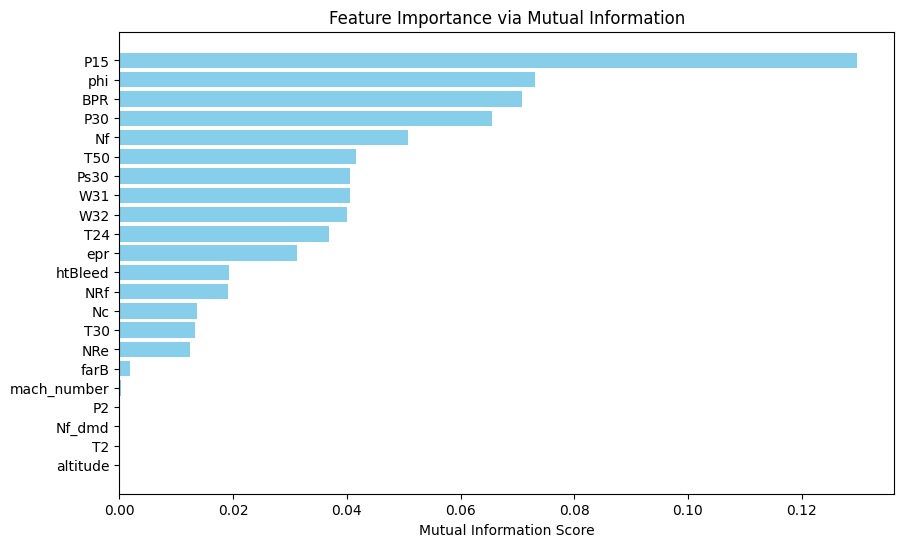

In [98]:
# MUTUAL INFORMATION GAIN
from sklearn.feature_selection import mutual_info_classif
# Define predictors and target
X = dataset4[['altitude', 'mach_number', 'T2', 'T24', 'T30', 'T50', 'P2', 'P15', 
              'P30', 'Nf', 'Nc', 'epr', 'Ps30', 'phi', 'NRf', 'NRe', 'BPR', 'farB', 
              'htBleed', 'Nf_dmd', 'W31', 'W32']]  # predictors
y = dataset4['health_state_final']  # target

# Compute mutual information
mi_scores = mutual_info_classif(X, y, discrete_features=False, random_state=42)
mi_df = pd.DataFrame({'feature': X.columns, 'MI_score': mi_scores}).sort_values(by='MI_score', ascending=False)
plt.figure(figsize=(10,6))
plt.barh(mi_df['feature'], mi_df['MI_score'], color='skyblue')
plt.xlabel('Mutual Information Score')
plt.title('Feature Importance via Mutual Information')
plt.gca().invert_yaxis()
plt.show()


In [100]:
# Define top 10 features
top_10_features = ['P15', 'phi', 'BPR', 'P30', 'Nf', 'T50', 'Ps30', 'W31', 'W32', 'T24']

# Include target column
dataset4selected = dataset4[top_10_features + ['health_state_final']]

# Display first few rows
dataset4selected.head(3)


P15     phi     BPR     P30       Nf      T50   Ps30    W31      W32  \
0   5.70  129.78  9.3335  137.36  2211.86  1112.93  41.69  10.62   6.3670   
1  13.61  312.59  9.1913  332.10  2323.66  1237.50  43.94  24.37  14.6552   
2   5.69  129.62  9.4007  138.18  2211.92  1117.05  41.66  10.48   6.4213   

      T24 health_state_final  
0  549.68          Degrading  
1  606.07          Degrading  
2  548.95          Degrading

/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning:

invalid value encountered in less



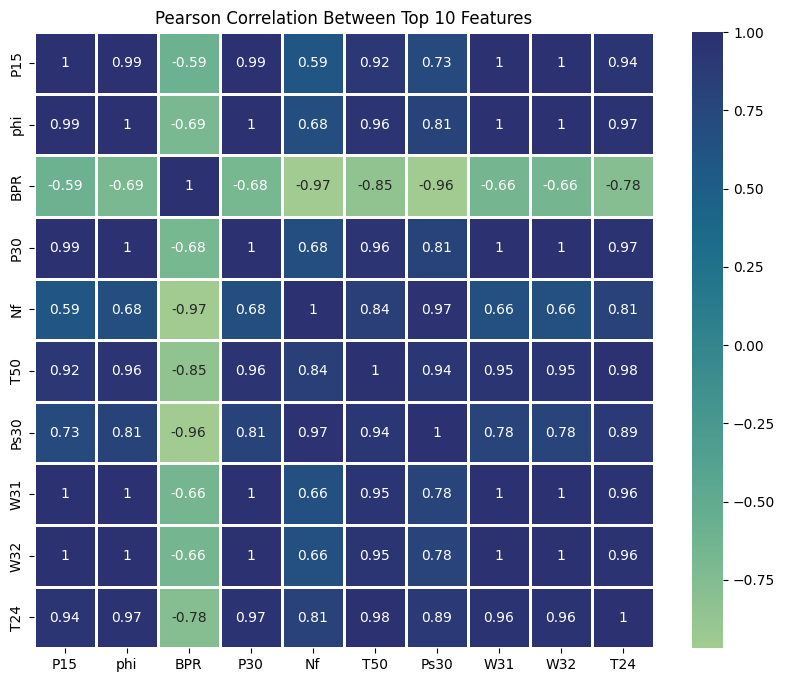

In [106]:
# Compute Pearson correlation matrix
corr_matrix = dataset4selected[top_10_features].corr(method='pearson')
# Display correlation heatmap
plt.figure(figsize=(10,8))
sns.heatmap(corr_matrix, annot=True, cmap='crest', center=0, linewidths=1, linecolor='white')
plt.title('Pearson Correlation Between Top 10 Features')
plt.show()

In [109]:
import h2o
from h2o.automl import H2OAutoML

# Initialize H2O cluster
h2o.init(max_mem_size="8G")

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.27" 2025-04-15; OpenJDK Runtime Environment (build 11.0.27+6-post-Ubuntu-0ubuntu122.04); OpenJDK 64-Bit Server VM (build 11.0.27+6-post-Ubuntu-0ubuntu122.04, mixed mode, sharing)
  Starting server from /usr/local/lib/python3.11/dist-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmp7vdh3xek
  JVM stdout: /tmp/tmp7vdh3xek/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmp7vdh3xek/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.
Please download and install the latest version from: https://h2o-release.s3.amazonaws.com/h2o/latest_stable.html


--------------------------  -----------------------------------------------------------------------------------------
H2O_cluster_uptime:         03 secs
H2O_cluster_timezone:       Etc/UTC
H2O_data_parsing_timezone:  UTC
H2O_cluster_version:        3.46.0.7
H2O_cluster_version_age:    4 months and 22 days
H2O_cluster_name:           H2O_from_python_unknownUser_i6ev80
H2O_cluster_total_nodes:    1
H2O_cluster_free_memory:    8 Gb
H2O_cluster_total_cores:    4
H2O_cluster_allowed_cores:  4
H2O_cluster_status:         locked, healthy
H2O_connection_url:         http://127.0.0.1:54321
H2O_connection_proxy:       {"http": null, "https": null, "colab_language_server": "/usr/colab/bin/language_service"}
H2O_internal_security:      False
Python_version:             3.11.13 final
--------------------------  -----------------------------------------------------------------------------------------

In [110]:
# Use all top-10 features
features = ['P15', 'phi', 'BPR', 'P30', 'Nf', 'T50', 'Ps30', 'W31', 'W32', 'T24']
target = 'health_state_final'

# Convert to H2OFrame
hf = h2o.H2OFrame(dataset4selected[features + [target]])
hf[target] = hf[target].asfactor()  # Ensure target is categorical


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


AutoML progress: |███████████████████████████████████████████████████████████████| (done) 100%
model_id                              mean_per_class_error    logloss      rmse       mse
XGBoost_3_AutoML_1_20250819_121252                0.47734    0.891168  0.57119   0.326258
GBM_2_AutoML_1_20250819_121252                    0.478414   0.891164  0.571388  0.326485
GBM_3_AutoML_1_20250819_121252                    0.481903   0.890796  0.571073  0.326124
GBM_1_AutoML_1_20250819_121252                    0.482216   0.891035  0.571232  0.326306
XGBoost_2_AutoML_1_20250819_121252                0.487991   0.902817  0.572124  0.327326
GBM_4_AutoML_1_20250819_121252                    0.488298   0.892799  0.571269  0.326348
XGBoost_1_AutoML_1_20250819_121252                0.493091   0.919148  0.575559  0.331268
DRF_1_AutoML_1_20250819_121252                    0.519485   0.907644  0.572695  0.327979
GLM_1_AutoML_1_20250819_121252                    0.586512   0.95716   0.601423  0.36171
[9 row

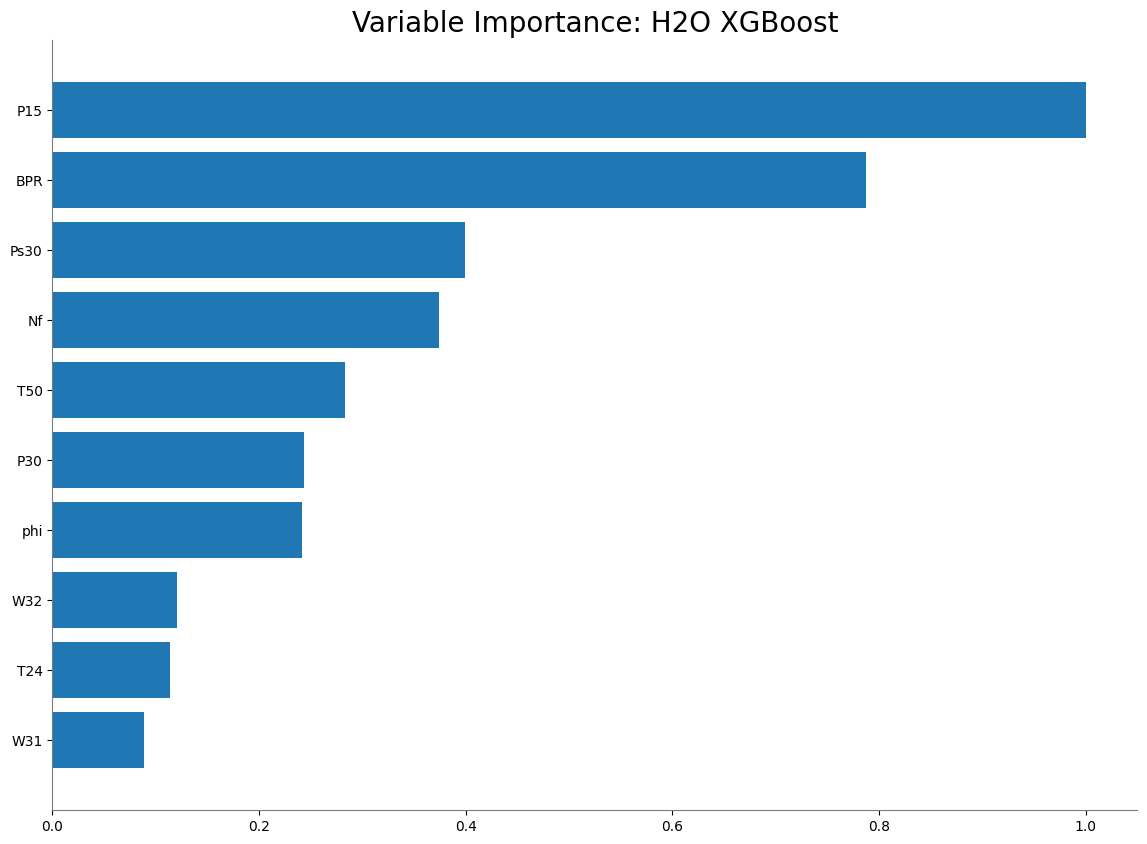

xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%


/usr/local/lib/python3.11/dist-packages/h2o/frame.py:1983: H2ODependencyWarning:

Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)




<Figure size 640x480 with 0 Axes>

In [112]:
aml = H2OAutoML(
    max_runtime_secs=600,  # 10 minutes
    seed=42,
    balance_classes=True,
    max_models=20,
    nfolds=5              # 5-fold cross-validation
)

# Train AutoML on full dataset
aml.train(x=features, y=target, training_frame=hf)

# -----------------------------
#  View leaderboard
# -----------------------------
lb = aml.leaderboard
print(lb.head(rows=10))  # top 10 models

# -----------------------------
# Evaluate leader model
# -----------------------------
leader = aml.leader

# Cross-validated metrics
print(leader.cross_validation_metrics_summary())

# -----------------------------
#  Feature importance (if tree-based)
# -----------------------------
if leader.varimp() is not None:
    leader.varimp_plot()

# -----------------------------
#  Predict on the same dataset (or new data)
# -----------------------------
preds = leader.predict(hf)
preds_df = preds.as_data_frame()  # convert to pandas DataFrame

# Combine predictions with original data
results_df = dataset4selected.copy()
results_df['predicted_health_state'] = preds_df['predict']

# -----------------------------
# Save predictions to CSV
# -----------------------------
results_df.to_csv('dataset4selected_predictions.csv', index=False)

In [114]:
# -----------------------------
# 1. Calculate uncapped RUL for each engine
# -----------------------------
# Get maximum cycle per engine
engine_max_cycle = dataset4.groupby('engine_id')['cycle'].max().reset_index()
engine_max_cycle.rename(columns={'cycle': 'max_cycle'}, inplace=True)

# Merge max_cycle back to dataset4
dataset4 = dataset4.merge(engine_max_cycle, on='engine_id', how='left')

# Calculate uncapped RUL
dataset4['RUL_uncapped'] = dataset4['max_cycle'] - dataset4['cycle']

# Drop the temporary max_cycle column
dataset4.drop(columns=['max_cycle'], inplace=True)

# -----------------------------
# 2. Assign health states based on domain-informed RUL thresholds
# -----------------------------
def assign_health_state(rul):
    if rul > 150:
        return 'Healthy'
    elif rul > 50:
        return 'Degrading'
    else:
        return 'Near-Failure'

dataset4['health_state_binned'] = dataset4['RUL_uncapped'].apply(assign_health_state)

# -----------------------------
# 3. Check the distribution of binned health states
# -----------------------------
print(dataset4['health_state_binned'].value_counts())


health_state_binned
Degrading       24799
Healthy         23751
Near-Failure    12699
Name: count, dtype: int64


Explained variance per component: PC1=0.8825, PC2=0.1101


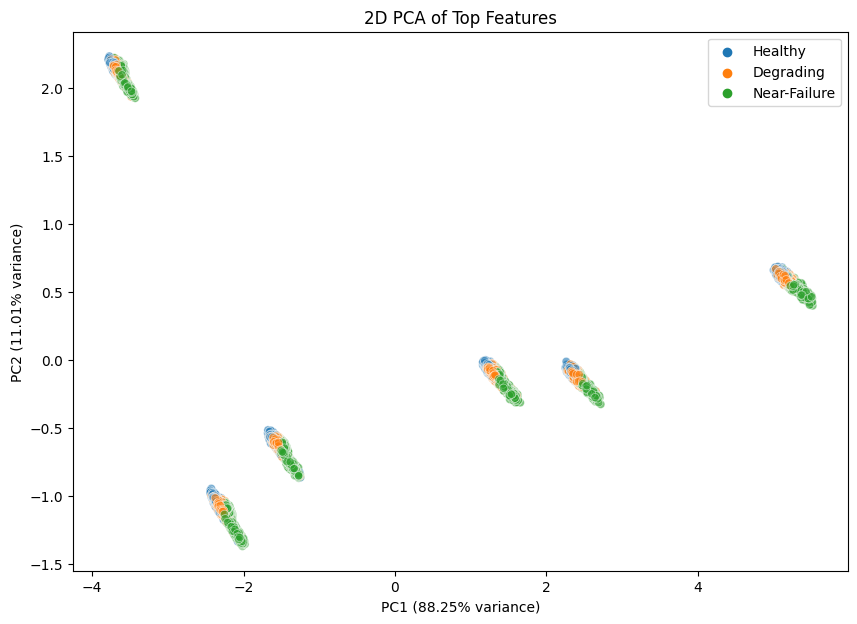

In [117]:
# -----------------------------
# 1. Select top features for PCA 2D ANALYSIS
# -----------------------------
top_features = ['P15', 'phi', 'BPR', 'P30', 'Nf', 'T50', 'Ps30', 'W31', 'W32', 'T24']

# Extract features
X = dataset4[top_features]

# -----------------------------
# 2. Standardize features
# -----------------------------
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# -----------------------------
# 3. Apply PCA
# -----------------------------
pca = PCA(n_components=2)  # 2D PCA
X_pca = pca.fit_transform(X_scaled)

# Explained variance
explained_variance = pca.explained_variance_ratio_
print(f"Explained variance per component: PC1={explained_variance[0]:.4f}, PC2={explained_variance[1]:.4f}")

# -----------------------------
# 4. Create a DataFrame for plotting
# -----------------------------
import pandas as pd
pca_df = pd.DataFrame({
    'PC1': X_pca[:,0],
    'PC2': X_pca[:,1],
    'health_state_binned': dataset4['health_state_binned']
})

# -----------------------------
# 5. Plot 2D PCA
# -----------------------------
plt.figure(figsize=(10,7))
sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='health_state_binned', alpha=0.6)
plt.title('2D PCA of Top Features')
plt.xlabel(f'PC1 ({explained_variance[0]*100:.2f}% variance)')
plt.ylabel(f'PC2 ({explained_variance[1]*100:.2f}% variance)')
plt.legend()
plt.show()

In [118]:
# PCA loadings for PC1
pc1_loadings = pd.Series(pca.components_[0], index=top_features)
pc1_loadings_sorted = pc1_loadings.sort_values(ascending=False)

print("Features contributing to PC1 (sorted by impact):")
print(pc1_loadings_sorted)

Features contributing to PC1 (sorted by impact):
T50     0.334810
T24     0.333135
phi     0.327688
P30     0.327578
W31     0.324847
W32     0.324838
P15     0.316771
Ps30    0.309418
Nf      0.278893
BPR    -0.278076
dtype: float64


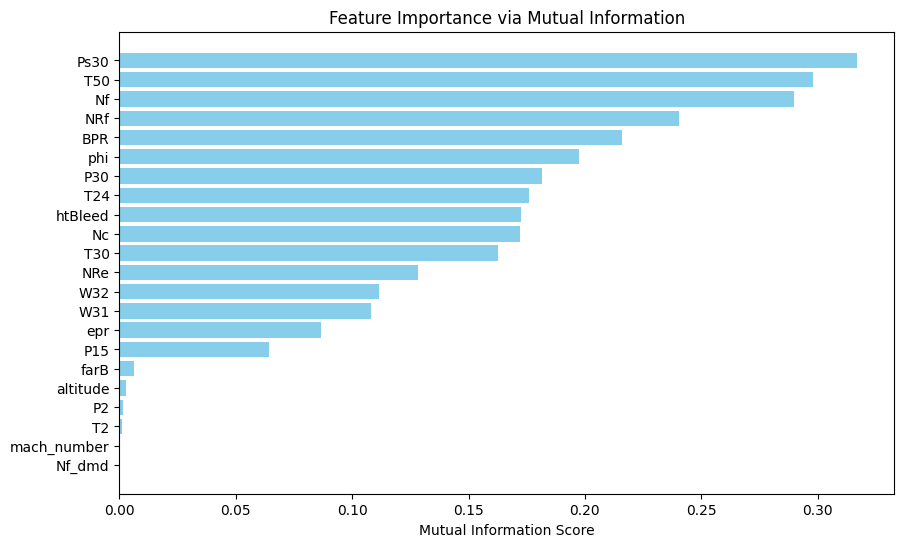

In [124]:
# MUTUAL INFORMATION GAIN
from sklearn.feature_selection import mutual_info_classif
# Define predictors and target
X = dataset4[['altitude', 'mach_number', 'T2', 'T24', 'T30', 'T50', 'P2', 'P15', 
              'P30', 'Nf', 'Nc', 'epr', 'Ps30', 'phi', 'NRf', 'NRe', 'BPR', 'farB', 
              'htBleed', 'Nf_dmd', 'W31', 'W32']]  # predictors
y = dataset4['health_state_binned']  # target

# Compute mutual information
mi_scores = mutual_info_classif(X, y, discrete_features=False, random_state=42)
mi_df = pd.DataFrame({'feature': X.columns, 'MI_score': mi_scores}).sort_values(by='MI_score', ascending=False)
plt.figure(figsize=(10,6))
plt.barh(mi_df['feature'], mi_df['MI_score'], color='skyblue')
plt.xlabel('Mutual Information Score')
plt.title('Feature Importance via Mutual Information')
plt.gca().invert_yaxis()
plt.show()


In [126]:
# 1. Select top 10 MI features
# -----------------------------
top_features = ['Ps30', 'T50', 'Nf', 'NRf', 'BPR', 'phi', 'P30', 'T24', 'htBleed', 'Nc']
target = 'health_state_binned'

# Make dataset4selected
dataset4selected = dataset4[top_features + [target]].copy() 
hf = h2o.H2OFrame(dataset4selected)
hf[target] = hf[target].asfactor()  # categorical target

# -----------------------------
# 3. Run H2O AutoML with k-fold CV
# -----------------------------
aml = H2OAutoML(
    max_models=10,        # limit number of models
    seed=42,
    max_runtime_secs=1800,
    balance_classes=True,
    nfolds=5,             # k-fold CV
    keep_cross_validation_predictions=True,
    sort_metric='mean_per_class_error'
)
aml.train(x=top_features, y=target, training_frame=hf)

# -----------------------------
# 4. Leaderboard & best model
# -----------------------------
lb = aml.leaderboard
lb.head(rows=10)

best_model = aml.leader
best_model.model_id

# -----------------------------
# 5. Cross-validated performance metrics
# -----------------------------
perf_cv = best_model.cross_validation_metrics_summary()
perf_cv

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
AutoML progress: |███████████████████████████████████████████████████████████████| (done) 100%


Cross-Validation Metrics Summary: 
                         mean      sd          cv_1_valid    cv_2_valid    cv_3_valid    cv_4_valid    cv_5_valid
-----------------------  --------  ----------  ------------  ------------  ------------  ------------  ------------
accuracy                 0.724132  0.00477932  0.72409       0.725354      0.730098      0.716768      0.72435
aic                      nan       0           nan           nan           nan           nan           nan
auc                      nan       0           nan           nan           nan           nan           nan
err                      0.275868  0.00477932  0.27591       0.274646      0.269902      0.283232      0.27565
err_count                3379      36.3593     3381          3371          3343          3439          3361
loglikelihood            0         0           0             0             0             0             0
logloss                  0.575489  0.00733684  0.57735       0.571795      0.565716      0.585496      0.57709
max_per_class_error      0.351262  0.00424819  0.353663      0.356136      0.34535       0.352422      0.34874
mean_per_class_accuracy  0.741447  0.00607813  0.743019      0.741653      0.748452      0.731688      0.742423
mean_per_class_error     0.258553  0.00607813  0.256981      0.258347      0.251548      0.268312      0.257577
mse                      0.191855  0.00221064  0.192356      0.191111      0.188622      0.194654      0.19253
null_deviance            25962.6   266.677     25959.8       26108.2       26325.6       25667.8       25751.4
pr_auc                   nan       0           nan           nan           nan           nan           nan
r2                       0.665165  0.00737651  0.66409       0.669048      0.674916      0.655179      0.662592
residual_deviance        14098.2   84.5642     14149.7       14036.4       14013.9       14218.2       14072.9
rmse                     0.438006  0.00252556  0.438584      0.437163      0.434306      0.441196      0.438782